In [33]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [34]:
# Đọc tệp shapefile sử dụng GeoPandas
gdf = gpd.read_file('../Data/gadm41_VNM_2.shp')

# Filter for TP.HCM
gdf_hcm = gdf[gdf['NAME_1'] == 'Há»\x93 ChÃ\xad Minh']

# Rename column "VARNAME2" to"District" 
gdf_hcm = gdf_hcm.rename(columns={'VARNAME_2': 'District'})

# Reformatting name of district
replace_dict = {'Binh Chanh':'binh-chanh', 'Binh Tan' : 'binh-tan','Binh Thanh':'binh-thanh', 'Can Gio':'can-gio', 
 'Cu Chi':'cu-chi', 'Go Vap':'go-vap', 'Hoc Mon':'hoc-mon', 'Nha Be':'nha-be', 'Phu Nhuan':'phu-nhuan', 
 'District 1':'quan-1', 'District 10':'quan-10', 'District 11':'quan-11', 'District 12':'quan-12', 'District 2':'quan-2', 
 'District 3':'quan-3', 'District 4':'quan-4', 'District 5':'quan-5', 'District 6':'quan-6', 'District 7':'quan-7', 
 'District 8':'quan-8', 'District 9':'quan-9', 'Tan Binh':'tan-binh',  'Tan Phu':'tan-phu', 'Thu Duc':'thu-duc'}
gdf_hcm['District'] = gdf_hcm['District'].replace(replace_dict)

In [35]:
# Read cleaned file with district
df = pd.read_csv('../Data/data_with_district.csv')

# Keep columns 'District','Price_per_sqm','Month' in dataframe
df = df[['District','Price_per_sqm','Month']]

# Merge geodataframe and dataframe to a new file csv contain data and geodata
df = gdf_hcm.merge(df, on='District')
df.to_csv('../Data/data_with_gadm.csv', index = False)

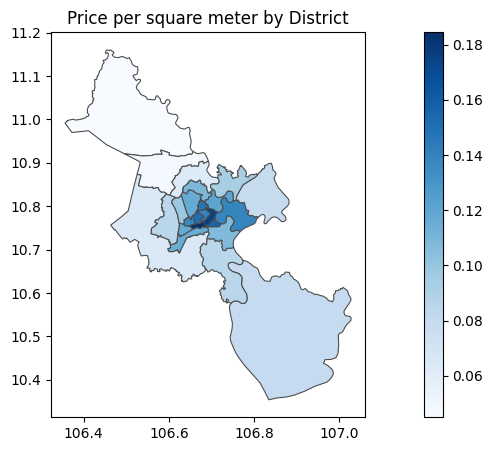

In [36]:
# Nhóm dữ liệu theo cột 'District' và tính giá trị trung bình của 'Price_per_sqm' cho mỗi quận
price_per_sqm_mean_by_district = df.groupby('District')['Price_per_sqm'].mean().reset_index()

# Đổi tên cột để rõ ràng hơn
price_per_sqm_mean_by_district.rename(columns={'Price_per_sqm': 'price_per_sqm_mean'}, inplace=True)

# Hợp nhất dữ liệu số lượng nhà bán với dữ liệu bản đồ hành chính
gdf = gdf_hcm.merge(price_per_sqm_mean_by_district, on='District')

# Vẽ bản đồ nhiệt
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

gdf.plot(column='price_per_sqm_mean', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.3', legend=True)

plt.title('Price per square meter by District')
plt.show()

**Visualize a heatmap based on the price per square meter by District** 
* Các quận ở trung tâm có màu đậm hơn, biểu thị giá đất cao hơn so với các quận ở ngoại thành có màu nhạt hơn.

* Vùng trung tâm của bản đồ có giá đất cao nhất, được biểu thị bằng màu xanh đậm nhất, càng ra xa vùng trung tâm, màu xanh thể hiện giá đất càng nhạt


**Conclusion** 
* Giá đất biểu thị trong biểu đồ là hợp lý so với thực tế.

* Bộ dữ liệu sau khi xử lý có độ tin cậy cao, phù hợp để huấn luyện các mô hình máy học dự đoán giá nhà.

In [37]:
data = pd.read_csv('../Data/data_with_gadm.csv')

# Chuyển đổi cột 'geometry' sang GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.GeoSeries.from_wkt(data['geometry']))

# Trích xuất tọa độ trung tâm của mỗi quận
gdf['centroid'] = gdf.geometry.centroid.apply(lambda point: (point.x, point.y))

# Trích xuất tọa độ
coordinates = np.array(gdf['centroid'].tolist())

# Tạo KDE
kde = KernelDensity(bandwidth=0.015, metric='euclidean')
kde.fit(coordinates)

KernelDensity(bandwidth=0.015)

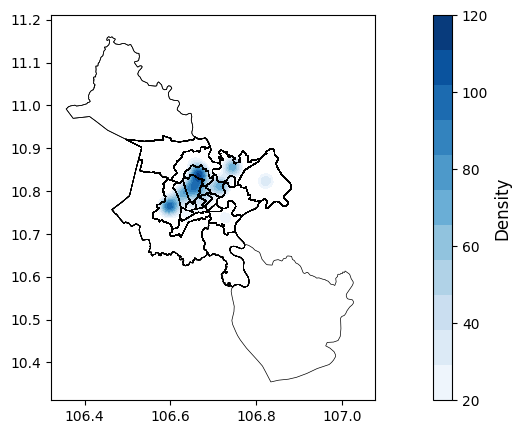

In [40]:
# Đánh giá KDE trên một lưới điểm
xmin, ymin, xmax, ymax = gdf.total_bounds
xgrid = np.linspace(xmin + 0.05, xmax + 0.05, 100)
ygrid = np.linspace(ymin + 0.05, ymax + 0.05, 100)
X, Y = np.meshgrid(xgrid, ygrid)
xy_sample = np.vstack([X.ravel(), Y.ravel()]).T
Z = kde.score_samples(xy_sample)
Z = np.exp(Z).reshape(X.shape)

# Vẽ heatmap
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
contour = ax.contourf(X, Y, Z, levels=np.linspace(20, 120, 12), cmap='Blues')

# Thêm và tùy chỉnh color bar
cbar = plt.colorbar(contour, ax = ax)
cbar.ax.tick_params(labelsize = 10)  # Thay đổi kích thước nhãn
cbar.set_label('Density', size = 12)  # Đặt tiêu đề cho color bar
cbar.set_ticks(np.linspace(20, 120, 6))  # Đặt các mốc giá trị

# Vẽ bản đồ quận
gdf.boundary.plot(ax = plt.gca(), linewidth = 0.5, edgecolor = 'black')
plt.show()

**Visualize a heatmap based on the district of the listed house using kernel density estimation**
* Các khu vực màu xanh đậm có mật độ nhà bán cao nhất, tập trung ở vùng gần khu vực trung tâm 

* Các vùng màu xanh vừa đại diện cho các khu vực có mật độ nhà bán trung bình, bao quanh các khu vực có mật độ cao, cho thấy mật độ nhà bán giảm dần khi di chuyển ra khỏi trung tâm.

* Các vùng màu xanh nhạt và trắng biểu thị các khu vực có mật độ nhà bán thấp, nằm ở vùng ngoại vi của bản đồ, cho thấy các quận ngoại thành có ít nhà được liệt kê bán hơn